In [1]:
%load_ext autoreload
%autoreload 2
import os
import data_prep as dp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import imgaug as ia
import imgaug.augmenters as iaa
import cv2

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

Using TensorFlow backend.


# Modelling

In this notebook I will build a baseline model and then show which different layers can affect them.
Training takes sometime (especially if not using the cloud) so it has been hashed out.

In [2]:
# Set the environment seed for Python
os.environ['PYTHONHASHSEED'] = '0'

seed=101

# Set seed for Numpy
np.random.seed(seed)

## Read in Data

### Train

In [173]:
# Find and label each image according to class
filer = dp.Files()
normal = filer.find_files('Docs/all_xrays/train/normal', "0001").files
virus = filer.find_files('Docs/all_xrays/train/virus', "virus").files
bacteria = filer.find_files('Docs/all_xrays/train/bacteria', "bacteria").files

# Use a list comprehension to get a complete list of files and their corresponding labels
train_dataset = [(i,0) for i in normal]
train_dataset += [(i,1) for i in virus]
train_dataset += [(i,2) for i in bacteria]

# Convert list to dataframe        
df_train = pd.DataFrame(train_dataset, columns=("file","class"))
df_train['class'] = df_train['class'].astype(dtype='category')

# Check the number of files in each class 
df_train['class'].value_counts() # 0 = Normal; 1 = Virus; 2 = Bacteria


2    2196
0    1249
1    1179
Name: class, dtype: int64

In [175]:
len(normal),len(virus),len(bacteria)

(1249, 1179, 2196)

In [3]:
directory='Docs/all_xrays/train/'
subfolders=['normal','virus','bacteria']
class_labels=[0,1,2]

train_data, train_labels = dp.image_data_and_labels('.jpeg',directory,subfolders,class_labels)

print("Total number of train examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of train examples:  (4625, 224, 224, 3)
Total number of labels: (4625, 3)


### Validation
We need a validation dataset so we can check for overfitting during training as cross-validation requires re-training per k-fold and would be far too time consuming for a neural network.

In [91]:
# Same as for training data
# Find and label each image according to class

normal = filer.find_files('Docs/all_xrays/val/normal', "0001").files
virus = filer.find_files('Docs/all_xrays/val/virus', "virus").files
bacteria = filer.find_files('Docs/all_xrays/val/bacteria', "bacteria").files

# Use a list comprehension to get a complete list of files and their corresponding labels
validation_dataset = [(i,0) for i in normal]
validation_dataset += [(i,1) for i in virus]
validation_dataset += [(i,2) for i in bacteria]

# Convert list to dataframe        
df_val = pd.DataFrame(validation_dataset, columns=("file","class"))
df_val['class'] = df_val['class'].astype(dtype='category')

# Check the number of files in each class 
df_val['class'].value_counts() # 0 = Normal; 1 = Virus; 2 = Bacteria


2    27
0    15
1    14
Name: class, dtype: int64

In [7]:
directory='Docs/all_xrays/val/'
subfolders=['normal','virus','bacteria']
class_labels=[0,1,2] # Allows changing of problem from binary or multi-class

# Reads the image location and directory, converts data to array and labels the class accordingly
val_data, val_labels = dp.image_data_and_labels('.jpeg',directory,subfolders,class_labels)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

Total number of validation examples:  (56, 224, 224, 3)
Total number of labels: (56, 3)


## Building the Model
I will be using the VGG16 neural network as this has been pre-trained on ImageNet (dataset of over 14 million images), achieving 92.7% accuracy. It surpasses AlexNet network by replacing large filters of size 11 and 5 in the first and second convolution layers with small size 3x3 filters.

### Basic Model
This will be a baseline model as it has a simple structure with no dropout, batch normalization or separable convolutional. It conists of 2D convolutions and a max pooling layer as well as initial transfer learning from VGG16.

Neural Networks are greedy learners - meaning they often require lots of data to achieve high success. Transfer learning is a useful tool when dealing with smaller data sets such as this as it can provide the neural network with the ability to recognise certain features such as edges and colours.

I will also specify the learning rate of the optimiser, here in this case it is set at 0.001. If our training loss begins to explode (increase rapidly), we will have likely overshot the global minimum and as a result should reduce the learning rate. If we find the loss is not decreasing substantially over several epochs it could be a sign to increase the learning rate.

In [9]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()

### Initial (Baseline) Model

In [10]:
# model = Sequential()


# # VGG16 first few layers - currently not "frozen".
# model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[0])
# model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[1])
# model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[2])
# model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[3])

# # First 2D convolutions (x3) then max pooling. Produces 256 filters.
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_1'))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_2'))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_3'))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool1'))

# # Second 2D convolutions (x3) then max pooling. Produces 512 filters.
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_1'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_2'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_3'))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool2'))

# # Thirds 2D convolutions (x3) then max pooling. Produces 512 filters.
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_1'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_2'))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_3'))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool3'))

# # Flatten all weights into one layer - this produces the largest number of parameters
# # Further reduce the units (number of neurons) before using a final softmax layer to produce our 3 outputs (classes)
# model.add(Flatten(name="Flatten"))
# model.add(Dense(units=1024, activation="relu", name='Dense1'))
# model.add(Dense(units=512, activation="relu", name='Dense2'))
# model.add(Dense(units=3, activation="softmax", name='Result'))

### "Improved" Model

This model has been optimised:
* There are additional convolution layers with more filters
* Same transfer learning from VGG16
* Batch Normalization
* Dropout Layers

This has been performed after training many different models and comparing the training and validation accuracies. This has not been compared to any of the Test data.

In [172]:
from keras.layers import SeparableConv2D, BatchNormalization, Dropout

model = Sequential()

size=(224,224)

# VGG16 first few layers - currently not "frozen".
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[0])
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[1])
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[2])
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[3])

# Convolutions - SeperableConvolution2D uses fewer parameters than Conv2D (64 filters)
model.add(SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_1'))
model.add(SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_2'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool1'))

# Convolutions (128 filters)
model.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_1'))
model.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_2'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool2'))

# Convolutions (128 filters)
model.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_1'))
model.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_2'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool3'))

# Convolutions (256 filters) + Batch Normalization for Adaptive Histogram Equalization (maintains normal distribution)
model.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_1'))
model.add(BatchNormalization())
model.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_2'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool4'))

# Convolutions (256 filters) + Batch Normalization
model.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_1'))
model.add(BatchNormalization())
model.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_2'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool5'))

# Convolutions (512 filters) + Batch Normalization  + Dropout (20%) to help reduce overfitting
model.add(SeparableConv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv6_1'))
model.add(BatchNormalization())
model.add(SeparableConv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv6_2'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool6'))
model.add(Dropout(0.2))

# Final layer - Flatten all paramaters into one layer of 1024 nodes decreasing to 512 and then 3 output nodes + Dropouts
model.add(Flatten(name="Flatten"))
model.add(Dense(units=1024,activation="relu", name='Dense1'))
model.add(Dropout(0.2))
model.add(Dense(units=512,activation="relu", name='Dense2'))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation="softmax", name='Result'))

In [149]:
# Freezing the initial layers (VGG16) to prevent training and allow transfer learning to our model.

for layer in model.layers[:3]:
    layer.trainable=False

# See the full model architecture, image shape + number of filters and the number of parameters in each layer.
# Fewer parameters reduces training time.
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
Conv1_1 (SeparableConv2D)    (None, 112, 112, 64)      4736      
_________________________________________________________________
Conv1_2 (SeparableConv2D)    (None, 112, 112, 64)      4736      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 56, 56, 64)        0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 56, 56, 128)     

### Define Augmentations

In [150]:
ia.seed(seed)

seq = iaa.OneOf(random_state=seed,          # Chooses one of the below augmentations
                children=[
                iaa.Affine(rotate=(-5,5)),  # Size of rotation range in degrees
                iaa.Crop(percent=(0, 0.05)),# Percent of image cropped           
                iaa.Multiply((0.8, 1.2)),   # Makes pixels darker or brighter, random amount between 1.2 and 1.5
                ])


# It is better to start simple and slowly build up both the data generator and model to avoid overcomplicating things.
# This allows the user to more easily identify what changes produce which results.

### Define Optimizer, Early Stopping and Checkpoint Parameters and Compile Model

In [169]:
# If in local minima while training, Adam optimiser will help get out of local minima and reach global minimum.
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Checkpoint to save weights for each epoch. 
checkpoint = ModelCheckpoint("baseline.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Will stop training if no decrease in validation loss over 20 epochs (patience)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Initial learning rate - affects the rate of gradient descent. Increase if loss does not reduce.
opt = Adam(lr=0.005) 
# Compiles model for training. As we are looking at categorical classes we use categorical cross-entropy loss function.
# Accuracy will be evaluated and displayed at the end of each epoch.
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Begin Training

In [171]:
# Number of images in each batch (save on RAM) and number of steps to cycle through all available images.
batch_size = 16
steps = len(df_train)/batch_size

# Fit model and begin training. Save the accuracy and loss for each epoch as 'hist' for plotting later
hist = model.fit_generator(steps_per_epoch = steps, 
                           generator = dp.data_generator_3class(df_train,batch_size,'Docs/all_xrays/train/'),
                           validation_data = (val_data,val_labels), epochs=40, callbacks = [checkpoint, early])



### Save Model

In [95]:
# Save the weights of the model as an h5 file. Save only when necessary as files are LARGE! (Github limit=2GB)

# model.save('Baseline_Model_10steps.h5')


### Visualize Training

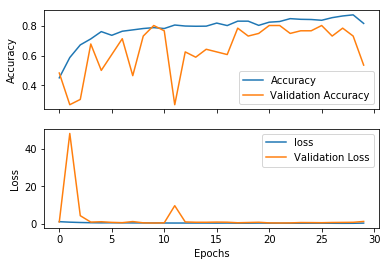

In [108]:
# Plot the accuracy and loss for the training and validation steps for every epoch.
# Reveals how much the model is improving and an idea of overfitting 
# If val_loss decreases while training increases - OVERFITTING

fig, (ax1,ax2) = plt.subplots(nrows=2,sharex='col',)

ax1.plot(hist.history["accuracy"])
ax1.plot(hist.history['val_accuracy'])
ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_xlabel("Epochs")
ax1.legend(["Accuracy","Validation Accuracy"])
ax2.legend(["loss","Validation Loss"])
ax1.set_ylabel("Accuracy")
ax2.set_ylabel('Loss')
plt.show()
# plt.savefig("Multi_SepConv_80val.png")

From the above plot one can see the accuracy for the training set is steadily improving while the validation accuracy is dropping off after the 26th epoch. This implies the model is overfitting and that the weights from an earlier epoch (25th) should be loaded when testing the model as these are the best performing weights before overfitting.

Once finished adjusting model and training, try testing the models weights in the Testing_Model Notebook.